# Overview

This notebook will be in charge of demonstrating how the system works. I not intended by any chance that this approach would be used in a productive environment (not even development) as there are other options as dockerizing and hosting the service in a microservice-like architecture (using fastAPI for example) or even recurring to cloud based solutions as AWS Bedrock to create a flow and expose as an endpoint without the overhead of de deployment process.

Nevertheles, one could think that the job that this notebook will do is basically what would happen at a user query time. The proposed architecture is only composed of 2 main steps, the retrieval and generation, this is not a productive architecture by any chance as other several components as *intent classifiers*, *routers*, *guardrails* could be applied too (always balancing the cost-latency tradeoff)

The reasons on why this approach was selected to address this takehome assesment are already detailed in the README file you can find at the root of this repository.

---
# Setup

Before we start, it's needed to perform some setup for our environment as installing the needed libraries, loading the ENV variables, config files and downloading the data model that was trained in the training pipeline (please refer to /model_training)

In [1]:
%pip install --quiet -r rag_system/requirements.txt

You should consider upgrading via the '/Users/nicolas.dominutti/Desktop/ml/medical-qa-system/.venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from dotenv import load_dotenv
load_dotenv("rag_system/.env")
MODEL_PATH = 'rag_system/model'

In [3]:
from general_utils import load_config
CONFIG = load_config()

In [4]:
from general_utils import S3Manager
s3_client = S3Manager.get_client()

Specifically in the following cell I will download the fine-tuned FlagEmbedding bge-base-en-v1.5 model, then I'll load it utilizing the FlagEmbedding library. It's important to recall that the selected model is *instruction tuned*, so I will pass it the very same instruction used at fine-tuning time

In [5]:
import os
if not os.listdir(MODEL_PATH):
    #run only if the model was not already downloaded
    S3Manager.download_folder(s3_client, CONFIG['S3_BUCKET'], 'finetuned_model/', MODEL_PATH)

In [6]:
from general_utils.flagembedding import FlagEmbeddingManager
embedding_service = FlagEmbeddingManager()
model = embedding_service.get_model(
    local_model_path=MODEL_PATH,
    query_instruction=CONFIG['QUERY_INSTRUCTION_AT_RETRIEVAL']
)

/Users/nicolas.dominutti/Desktop/ml/medical-qa-system/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
print(f"Utilized instruction: '{CONFIG['QUERY_INSTRUCTION_AT_RETRIEVAL']}'")

Utilized instruction: 'Represent this sentence for searching relevant passages:'


---

# Services access

After the setup is done, I'll proceed with initializing the connection to the needed services, as stated in the README file I will use:
* AWS OpenSearch: as the vector DB that stores the corpus embeddings produced with my fine-tuned model (please refer to /training) and allows me to perform semantic retrieval on them
* AWD Bedrock: as the fully managed solution to call the generator model API

The BedrockManager class (can be found in rag_system.utils.bedrock) encapsulates all the needed logic to query Bedrock. While the FlagEmbeddingManager class (can be found in general_utils.flagembedding) encapsulate the logic to connect and search from OpenSearch

In [8]:
from rag_system.utils import BedrockManager
bedrock = BedrockManager()

---

# Some examples

Here I'll provide some examples of retrieved context and responses from the model. It's worth it to notice that the utilized system prompt was not tuned due to a lack of time, being that a possible improvement spot.

In [9]:
print(f"Utilized untuned system prompt: {CONFIG['SYSTEM_PROMPT']}")

Utilized untuned system prompt:  You are a knowledgeable and empathetic medical assistant. Your task is to answer patients' questions strictly based on the context provided below. Do not include any information outside of this context. If the answer is not contained within the context, respond politely that you don’t have enough information to answer. Do not mention the context to the user, he doesn't knows about it.
Context {CONTEXT} 


In [11]:
from typing import Dict, Any, Optional
from FlagEmbedding.inference.embedder.encoder_only.base import BaseEmbedder

def chat(query:str, model: Optional[BaseEmbedder]=None) -> Dict[str,Any]:
    """
    Auxiliar function to concatenate the retrieval and generation steps.

    Args:
        query(str): user's query
    
    Returns:
        Dict[str,Any]: returned dict from Bedrock InvokeModel action. Contains
        the generation answer under the key 'generation'
    """
    if model:
        context = embedding_service.search(
            endpoint_url=CONFIG['OPENSEARCH_INDEX_URL'],
            flag_embedding_model=model, 
            query=query,
            top_k=CONFIG['ITEMS_TO_RETRIEVE']
        )
        system_prompt = CONFIG['SYSTEM_PROMPT']
    else:
        context = None
        system_prompt = """
            You are a knowledgeable and empathetic medical assistant. Your task is to answer patients' questions as best as you can. Avoid generating knowledge that is not factual based.
            If you are not sure if you can respond to a question, respond politely that you don’t have enough information to answer.
        """
    return bedrock.ask(
        query,
        CONFIG['MODEL'],
        system_prompt,
        CONFIG['TEMPERATURE'],
        CONFIG['TOP_P'],
        CONFIG['MAX_OUTPUT_TOKENS'],
        context
    ), context

In [ ]:
response, context = chat("What is high blood pressure?", model)
print(response['generation'])
print('')
print("\n".join([x for x in context]))

 High blood pressure, also known as hypertension, is a condition where the force of blood pushing against the walls of the blood vessels is higher than normal. It occurs when your blood pressure rises and stays high over time, making the heart work too hard and potentially harming arteries and organs such as the heart, kidneys, brain, and eyes.
Blood pressure is the force of blood pushing against the walls of the blood vessels as the heart pumps blood. If your blood pressure rises and stays high over time, its called high blood pressure. High blood pressure is dangerous because it makes the heart work too hard, and the high force of the blood flow can harm arteries and organs such as the heart, kidneys, brain, and eyes.
High blood pressure is a common disease in which blood flows through blood vessels (arteries) at higher than normal pressures. What Is Blood Pressure? Blood pressure is the force of blood pushing against the walls of the blood vessels as the heart pumps blood. If your b

In [ ]:
response, context = chat("What is Dry Eye ?", model)
print("\n".join(response['generation']).split('.'))
print('')
print("\n".join([x for x in context]))

 Dry eye occurs when the eye does not produce tears properly, or when the tears are of poor quality and dry up quickly. This can lead to a variety of symptoms, such as discomfort and pain, stinging and burning, redness, a sandy or gritty feeling, blurry vision, and eye fatigue.

Dry eye occurs when the eye does not produce tears properly, or when the tears are of poor quality and dry up quickly. The eyes need tears for overall eye health and clear vision. Dry eye can last a short time or it can be an ongoing condition. It can include a variety of symptoms, such as discomfort and pain. Your eyes may sting and burn and you may have redness and a sandy or gritty feeling, as if something is in your eye. You may have blurry vision and you may feel eye fatigue. Having dry eyes can make it harder to do some activities, such as using a computer or reading for a long period of time, and it can make it hard to be in dry places, such as on an airplane. (This short video discusses causes, symptoms

> _Disclaimer_

Latency is a topic that was not addressed at all:
* for this test the embedding model was running at full precision (fp32) in a CPU
* the machine that hosts the AWS OpenSearch collection is the smallest one can get (t3.small)

One could think of hosting the embedding model in a Sagemaker Endpoint or also in a Bedrock one, reducing precision if needed and increase the machine size behind OpenSearch

---

### Evaluating the generation

One could evaluate this generation in different ways:
* reference free: for example with an LLM-as-a-judge to analize the helpfulness, toxicity and faithfulness from the answer
* reference based: metrics that leverage the fact that there is a golden dataset with labels for some answers


In my case, just as a final validation I will utilize the dataset that was provided as part of the assignment, I will follow a simple approach:

1. select a sample question
2. generate the response to that question
3. compare the generated response to the golden answer by utilizing BERTScore

In [ ]:
!pip install -q evaluate==0.4.5 bert_score

In [37]:
import pandas as pd
df = pd.read_csv('data_processing/data/intern_screening_dataset.csv')

In [70]:
subset = df[['question','answer']].sample(50, random_state=CONFIG['RANDOM_SEED'])
sample_questions = subset.question.tolist()
sample_answers = subset.answer.tolist()
sample_questions

['Is Juvenile Huntington disease inherited ?',
 'What are the treatments for nemaline myopathy ?',
 'What is (are) Hailey-Hailey disease ?',
 'Is transthyretin amyloidosis inherited ?',
 'How many people are affected by Balance Problems ?',
 'What is (are) Heart Diseases ?',
 'What is (are) Hyperkalemic periodic paralysis ?',
 'How to diagnose Prothrombin thrombophilia ?',
 'What are the genetic changes related to multiple system atrophy ?',
 'What are the symptoms of Spinocerebellar ataxia 21 ?',
 'What is (are) Medicare and Continuing Care ?',
 'What is (are) Peripheral Artery Disease ?',
 'What is (are) metatropic dysplasia ?',
 'What to do for Urinary Incontinence in Children ?',
 'What is (are) Autoimmune myocarditis ?',
 'Is Fragile X syndrome inherited ?',
 'What are the symptoms of Lambdoid synostosis ?',
 'What are the symptoms of Osteogenesis imperfecta ?',
 'What is (are) Hermansky-Pudlak syndrome ?',
 'What is (are) Short Bowel Syndrome ?',
 'What is (are) Gum (Periodontal)

In [71]:
rag_based_answers = []

for question in sample_questions:
    response, context = chat(question, model)
    rag_based_answers.append((response,context))

In [75]:
predictions = [x[0]['generation'] for x in rag_based_answers]
predictions

[' Yes, Juvenile Huntington disease is inherited. It is inherited in an autosomal dominant manner, meaning one copy of the altered gene in each cell is sufficient to cause the disorder. An affected person usually inherits the altered gene from one affected parent.',
 ' I don’t have enough information to answer those questions.',
 ' Hailey-Hailey disease is a hereditary blistering skin disease.',
 ' I don’t have enough information to answer.',
 ' According to the Centers for Disease Control and Prevention, an estimated 33.4 million American adults, which is about 14.8 percent, had a balance or dizziness problem during the past year.',
 ' Cardiomyopathy refers to diseases of the heart muscle. These diseases have many causes, signs and symptoms, and treatments. One type of cardiomyopathy is Familial hypertrophic cardiomyopathy, which is a heart condition characterized by thickening of the heart muscle.',
 ' Hyperkalemic periodic paralysis is a condition that causes episodes of extreme mus

In [76]:
from evaluate import load
bertscore = load("bertscore")
results = bertscore.compute(predictions=predictions, references=sample_answers, lang="en")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [83]:
import numpy as np
np.mean(results['precision']), np.mean(results['recall']), np.mean(results['f1'])

(np.float64(0.8655884373188019),
 np.float64(0.798524374961853),
 np.float64(0.8301306283473968))

We can see that the model is getting around 86% in precision, 80% in recall and 83% in F1 score

## Compare RAG vs ungrounded model

Now let's compare just a few samples of both the RAG and the generative model without context

In [ ]:
sample_questions = [
    "What is high blood pressure?",
    "How to know if I have prostate cancer?",
    "Does Alzheimer have a cure?",
    "My doctor told me my cousing might have diabetic retinopathy, I'm worrier, can you tell me what is that?",
    "If I take a paracetamol, will my hair grow blonde?"
]

In [74]:
rag_based_answers = []
ungrounded_answers = []

for question in sample_questions:
    response, _ = chat(question, model)
    rag_based_answers.append(response)

    response, _ = chat(question)
    ungrounded_answers.append(response)

#### Output size difference

In [ ]:
!pip install -q matplotlib==1.3.0

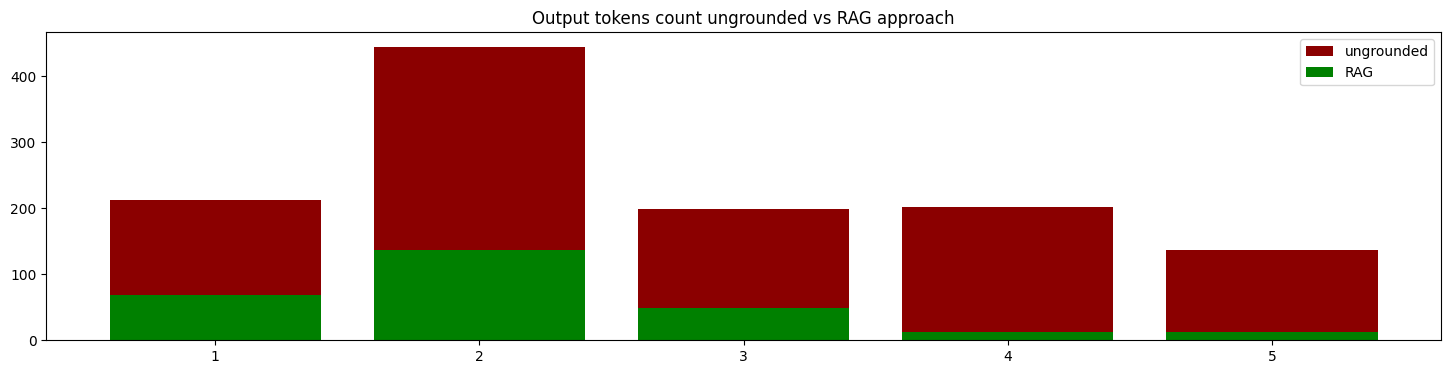

In [78]:
ungrounded_size = [ans['generation_token_count'] for ans in ungrounded_answers]
rag_size = [ans['generation_token_count'] for ans in rag_based_answers]

import matplotlib.pyplot as plt
plt.figure(figsize=(18,4))
plt.bar(x=range(1,6), height=ungrounded_size, label='ungrounded', color='darkred')
plt.bar(x=range(1,6), height=rag_size, label='RAG', color='green')
plt.legend()
plt.title('Output tokens count ungrounded vs RAG approach');

We can see that the ungrounded LLM tends to be much more verbose, while the RAG-based model produces more concise and focused answers grounded in the retrieved context.

#### Question on no available information

In [82]:
print("\n".join(u_ans[-1].split('.'))), rag_ans[-1]

I'm happy to help you with your question
 However, I must inform you that taking paracetamol will not affect the color of your hair
 Paracetamol is a medication used to relieve pain and reduce fever, and it does not have any properties that would influence hair color


Hair color is determined by the production of melanin in the hair follicle, and it's influenced by genetics, not by medications like paracetamol
 If you're interested in changing your hair color, you may want to consider consulting a hair care professional or using hair dye products specifically designed for that purpose


Please let me know if you have any other questions or concerns!


(None, 'I don’t have enough information to answer those questions.')

When the model isn't grounded, it's much more prone to generating hallucinated or inaccurate information, making it harder to control and less reliable.